In [133]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
import skimage
from skimage import exposure
from skimage.color import rgb2gray
from scipy.ndimage import convolve, uniform_filter
from skimage.filters import gabor_kernel, unsharp_mask, threshold_otsu, gabor
from skimage.morphology import disk, closing, dilation
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.vis import draw_bboxes
from utils.dataset import sliding_window
from utils.dataset import load_yolo_labels
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram
from utils.dataset import adjust_labels_for_pooling, resize_image_and_bboxes
from models.kernels import AlexNetDescriptor

In [134]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [135]:
def export_features(export_path, name, feature_name, feature_list):
    """Save features to npy file

    Args:
        export_path (str): path to save the file
        name (str): file name to save
        feature_name (str): name of the feature. Ex: 'lbp', 'hog', 'gabor'
        feature_list (list/array): list of features
    """
    ## Export features to file
    save_name = f'{name}_{feature_name}.npy'
    save_path = os.path.join(export_path, save_name)
    np.save(save_path, feature_list)
    print(f'Save {feature_name} features to {save_path}')

## Histogram Matching

In [136]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, image_folder, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

In [8]:
### Extract mean histogram from the training dataset
np.save('mean_hist.npy', mean_histogram)

In [ ]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [193]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Convert boolean mask to 8-bit integer
    binary_mask = binary_mask.astype(np.uint8) * 255  # Convert boolean to uint8
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    # final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))

    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour based on area
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    
    # Create a mask for the largest contour
    if largest_contour is not None:
        mask = np.zeros_like(binary_mask)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
        # Apply the mask to the original image
        final_image = cv2.bitwise_and(image, image, mask=mask)
    
    return final_image


In [194]:
def process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size=(4,4), resize=None):
    """
    Processes an image by preprocessing and loading corresponding labels, then applies pooling.

    Args:
    image_path (str): Path to the image file.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.
    unsharp (bool): Flag for unsharp mask processing.
    pool_size (tuple): Size of the pooling window.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    labels = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label
    image_name = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    if os.path.exists(label_path):
        labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth, unsharp=unsharp)
    
    # Apply pooling
    if pool_size is not None:
        img = skimage.measure.block_reduce(img, pool_size, np.max)
        # Adjust labels for pooling
        labels = adjust_labels_for_pooling(labels, img.shape, pool_size)
    if resize:
        img, labels = resize_image_and_bboxes(img, labels, resize)
        
    return img, labels

## Extract Features

In [195]:
import skimage.measure

probability_heatmap = np.load('./MLDataset/crop_heatmap.npy')
# Thresholding the image to segment the heatmap
_, segmented_image = cv2.threshold(probability_heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
crop_crowd_roi = np.array([cv2.boundingRect(contour) for contour in contours][-1])/probability_heatmap.shape[0]
crop_crowd_roi = np.array([crop_crowd_roi[0], crop_crowd_roi[1], crop_crowd_roi[0]+crop_crowd_roi[2], crop_crowd_roi[1]+crop_crowd_roi[3]])

GET_HARD_SAMPLES = False

def feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, descriptor, stepSize=128, windowSize=256, pool_size=(4, 4), heatmap=None):
    """
    Extract features from an image using a given descriptor.

    Args:
    - image_path (str): Path to the image file.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.
    - unsharp (bool): Flag for unsharp mask processing.
    - descriptor (object): The descriptor object to use for feature extraction.
    - show_grid (bool): Flag to show the grid of windows.

    Returns:
    - features (list): List of features extracted from the image.
    - labels_list (list): List of labels for each feature.
    """
    features = []
    labels_list = []
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size)
    ## scale heatmap to the same size as the image
    if heatmap is not None:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # feature_image = image     

    for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
            continue
        # ## Image histogram 
        window_f = skimage.measure.block_reduce(window_f, (2, 2), np.max)
        # Calculate the percentage of zero values
        zero_percentage = np.mean(window_f == 0) * 100
        if zero_percentage > 50:
            continue
        
        feature_image = descriptor(window_f)     
        feature = feature_image.ravel()
        if heatmap is not None:
            feature = np.append(feature, heatmap[y:y+windowSize, x:x+windowSize].ravel())
        
        iou_score = 0
        class_id = 0
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                class_id = 1
            elif iou_score > 0.1 and iou_score < 0.5:
                class_id = 0

        # if GET_HARD_SAMPLES:
        #     crop_crowd_roi_scaled = crop_crowd_roi * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
        #     area_percentage = calculate_boxA_percentage([x, y, x + windowSize, y + windowSize], crop_crowd_roi_scaled)
        #     if area_percentage < 0.5:
        #         continue
        
        features.append(feature)
        labels_list.append(class_id)

            
    return features, labels_list

In [196]:
windowSize = 64
stepSize = 32
pool_size = (4, 4)
# Parameters for LBP
num_points = 8  # Typically 8, 16, or 24
radius = 3       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [197]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
unsharp = True # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

### HOG

In [198]:
### Extract HOG features and export to npy file
from models.kernels import HogDescriptor

hogdes = HogDescriptor()

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                hogdes,
                stepSize=stepSize,
                windowSize=windowSize,
                pool_size=pool_size,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog",
            feature_list=labels_list,
        )

Processing 0/403 : MLDataset/crop_data/images/train/fracture/1009_1044044123_01_WRI-R2_M013.png
Processing 1/403 : MLDataset/crop_data/images/train/fracture/0685_0423920025_03_WRI-L2_M006.png
Processing 2/403 : MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png
Processing 3/403 : MLDataset/crop_data/images/train/fracture/1157_1136128863_02_WRI-L2_M012.png
Processing 4/403 : MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png
Processing 5/403 : MLDataset/crop_data/images/train/fracture/1009_1047321876_07_WRI-R1_M013.png
Processing 6/403 : MLDataset/crop_data/images/train/fracture/0749_0875713484_06_WRI-L1_M005.png
Processing 7/403 : MLDataset/crop_data/images/train/fracture/4708_0685185180_02_WRI-L3_M005.png
Processing 8/403 : MLDataset/crop_data/images/train/fracture/1226_0715562150_01_WRI-L2_F011.png
Processing 9/403 : MLDataset/crop_data/images/train/fracture/0600_0786418117_04_WRI-L2_F005.png
Processing 10/403 : MLDataset/crop_data/

### Hog - Canny Features

In [199]:
# Function to extract features using Canny edge detection
class CannyDescriptor:
    def __init__(self, threshold1=150, threshold2=200):
        self.threshold1 = threshold1
        self.threshold2 = threshold2

    def __call__(self, image):
        if image.ndim == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image
        edges = cv2.Canny(gray_image, self.threshold1, self.threshold2)
        feature, hog_image = skimage.feature.hog(
            edges,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
        )
        return feature.flatten()


canny_descriptor = CannyDescriptor()

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                canny_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog_canny",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog_canny",
            feature_list=labels_list,
        )

Processing 0/403 : MLDataset/crop_data/images/train/fracture/1009_1044044123_01_WRI-R2_M013.png
Processing 1/403 : MLDataset/crop_data/images/train/fracture/0685_0423920025_03_WRI-L2_M006.png
Processing 2/403 : MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png
Processing 3/403 : MLDataset/crop_data/images/train/fracture/1157_1136128863_02_WRI-L2_M012.png
Processing 4/403 : MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png
Processing 5/403 : MLDataset/crop_data/images/train/fracture/1009_1047321876_07_WRI-R1_M013.png
Processing 6/403 : MLDataset/crop_data/images/train/fracture/0749_0875713484_06_WRI-L1_M005.png
Processing 7/403 : MLDataset/crop_data/images/train/fracture/4708_0685185180_02_WRI-L3_M005.png
Processing 8/403 : MLDataset/crop_data/images/train/fracture/1226_0715562150_01_WRI-L2_F011.png
Processing 9/403 : MLDataset/crop_data/images/train/fracture/0600_0786418117_04_WRI-L2_F005.png
Processing 10/403 : MLDataset/crop_data/

### AlexNet Features

In [200]:
modes = ["train", "test"]
class_names = ["fracture", "normal"]

alexnet_descriptor = AlexNetDescriptor()

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                alexnet_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="alex",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_alex",
            feature_list=labels_list,
        )

/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing 0/403 : MLDataset/crop_data/images/train/fracture/1009_1044044123_01_WRI-R2_M013.png
Processing 1/403 : MLDataset/crop_data/images/train/fracture/0685_0423920025_03_WRI-L2_M006.png
Processing 2/403 : MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png
Processing 3/403 : MLDataset/crop_data/images/train/fracture/1157_1136128863_02_WRI-L2_M012.png
Processing 4/403 : MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png
Processing 5/403 : MLDataset/crop_data/images/train/fracture/1009_1047321876_07_WRI-R1_M013.png
Processing 6/403 : MLDataset/crop_data/images/train/fracture/0749_0875713484_06_WRI-L1_M005.png
Processing 7/403 : MLDataset/crop_data/images/train/fracture/4708_0685185180_02_WRI-L3_M005.png
Processing 8/403 : MLDataset/crop_data/images/train/fracture/1226_0715562150_01_WRI-L2_F011.png
Processing 9/403 : MLDataset/crop_data/images/train/fracture/0600_0786418117_04_WRI-L2_F005.png
Processing 10/403 : MLDataset/crop_data/

In [225]:
import math 
for i in range(100):
    if labels_list[i] == 1:
        print(labels_list[i])
        f_size = int(math.sqrt(len(features_list[i])))
        plt.imshow(features_list[i].reshape(f_size,f_size), cmap='gray')
        plt.show()

## Machine Learning Model

### Exploit crowded regions - Results are not good

### Load data

In [416]:
dataset_path = 'MLDataset/crop_data'

In [501]:
feature_list = ['hog', 'alex', 'hog_canny']
# feature_list =['hog',  'alex']

train_features_list = []
train_labels = None
test_features_list = []
test_labels = None

for feature_name in feature_list:
    # Load the dictionary from the .npz file
    train_fracture = np.load(os.path.join(root_path, f'train_fracture_{feature_name}.npy'), allow_pickle=True)
    train_normal = np.load(os.path.join(root_path, f'train_normal_{feature_name}.npy'), allow_pickle=True)
    train_fracture_labels = np.load(os.path.join(root_path, f'train_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    train_normal_labels = np.load(os.path.join(root_path, f'train_normal_labels_{feature_name}.npy'), allow_pickle=True)

    test_fracture = np.load(os.path.join(root_path, f'test_fracture_{feature_name}.npy'), allow_pickle=True)
    test_normal = np.load(os.path.join(root_path, f'test_normal_{feature_name}.npy'), allow_pickle=True)
    test_fracture_labels = np.load(os.path.join(root_path, f'test_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    test_normal_labels = np.load(os.path.join(root_path, f'test_normal_labels_{feature_name}.npy'), allow_pickle=True)

    train_features = np.concatenate([train_fracture, train_normal])
    train_labels= np.concatenate([train_fracture_labels, train_normal_labels])
    train_indices = np.where(train_labels!= -1)[0]
    train_features = train_features[train_indices]
    train_labels= train_labels[train_indices]

    test_features= np.concatenate([test_fracture, test_normal])
    test_labels = np.concatenate([test_fracture_labels, test_normal_labels])
    test_indices = np.where(test_labels!= -1)[0]
    test_features = test_features[test_indices]
    test_labels = test_labels[test_indices]
    
    # Append to the list
    train_features_list.append(train_features)
    test_features_list.append(test_features)

# Concatenate the features
train_features = np.concatenate(train_features_list, axis=1)
test_features = np.concatenate(test_features_list, axis=1)

In [502]:
train_features.shape, test_features.shape

((7814, 949), (2449, 949))

### Undersampling

In [503]:
import random
random.shuffle(list(range(len(train_features))))

In [504]:
# Split the dataset into majority and minority classes
X_majority = train_features[train_labels == 0]
y_majority = train_labels[train_labels == 0]
X_minority = train_features[train_labels == 1]
y_minority = train_labels[train_labels == 1]

# Downsample the majority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority,
                                                        y_majority,
                                                        replace=False,
                                                        n_samples=len(y_minority),
                                                        random_state=42)

# Combine the downsampled majority class with the minority class
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

In [505]:
np.unique(y_balanced, return_counts=True)

(array([0, 1]), array([1835, 1835]))

### Train Test Split

In [506]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
# X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [507]:
np.unique(train_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1]), array([5979, 1835])), (array([0, 1]), array([1996,  453])))

### Scaling

In [508]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_features = scaler.transform(test_features)

### Feature Selection

In [509]:
import mrmr
import pandas as pd

X_train_pd = pd.DataFrame(X_train)
y_train_pd = pd.Series(y_train)
test_features_pd = pd.DataFrame(test_features)

from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X_train_pd, y=y_train_pd, K=600)
print(selected_features)

In [510]:
X_val_pd = pd.DataFrame(X_val)

X_train = X_train_pd[selected_features].values
X_val = X_val_pd[selected_features].values
test_features = test_features_pd[selected_features].values

In [318]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

### Grid Search

In [258]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [50, 100],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Initialize the classifier
lgbm = lgb.LGBMClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, 
                        cv=5, n_jobs=-1, verbose=10, scoring='roc_auc')

# Fit Grid Search
grid_search.fit(X_balanced, y_balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 2/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 1/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 2/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 3/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 4/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 1/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 5/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[LightGBM] [Info] Number of positive: 1472, number of negative: 1472
[L

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.05], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100], 'num_leaves': [50, 100]},
             scoring='roc_auc', verbose=10)

In [263]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100}


### Training

In [494]:
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [511]:
# model = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=150)
model = SVC(C=100, kernel='rbf', gamma='auto', probability=True, degree=7, class_weight='balanced')
model.fit(X_train, y_train)


SVC(C=100, class_weight='balanced', degree=7, gamma='auto', probability=True)

In [512]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       367
           1       0.80      0.78      0.79       367

    accuracy                           0.79       734
   macro avg       0.79      0.79      0.79       734
weighted avg       0.79      0.79      0.79       734

[[293  74]
 [ 79 288]]
f1-score: 0.791543460465427


### Cross Validation

In [22]:
def cross_val_score(X, y, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    f1_scores = []
    best_model = None
    best_f1 = 0
    for train_index, val_index in kf.split(X):
        model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
        print(f'F1-score: {f1}')
        print(classification_report(y_val, y_pred))
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            
    return f1_scores, best_model

f1_scores, model = cross_val_score(X_balanced, y_balanced, cv=10)

[LightGBM] [Info] Number of positive: 1659, number of negative: 1653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196094
[LightGBM] [Info] Number of data points in the train set: 3312, number of used features: 769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500906 -> initscore=0.003623
[LightGBM] [Info] Start training from score 0.003623
F1-score: 0.787868100524206
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       187
           1       0.76      0.82      0.79       181

    accuracy                           0.79       368
   macro avg       0.79      0.79      0.79       368
weighted avg       0.79      0.79      0.79       368

[LightGBM] [Info] Number of positive: 1669, number of negative: 1643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

### Hard Mining

In [350]:
def identify_hard_negatives(X_test, y_test, classifier):
    predictions = classifier.predict(X_test)
    misclassified_indices = np.where(predictions != y_test)[0]
    hard_negatives = [X_test[i] for i in misclassified_indices]
    hard_negative_labels = [y_test[i] for i in misclassified_indices]
    return np.array(hard_negatives), np.array(hard_negative_labels)

def hard_negative_mining(X_train, y_train, X_test, y_test, classifier, iterations=5):
    for _ in range(iterations):
        # Identify hard negatives
        hard_negatives, hard_negative_labels = identify_hard_negatives(X_test, y_test, classifier)
        
        # Update training set
        X_train = np.concatenate((X_train, hard_negatives), axis=0)
        y_train = np.concatenate((y_train, hard_negative_labels), axis=0)

        # Retrain classifier
        classifier.fit(X_train, y_train)

        # Optional: Evaluate classifier on the test set after each iteration
        y_pred = classifier.predict(X_test)
        print(f"Iteration {_ + 1}")
        print(classification_report(y_test, y_pred))

    return classifier

In [477]:
model = hard_negative_mining(X_train, y_train, X_val, y_val, model, iterations=2)

Iteration 1
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       367
           1       0.98      0.97      0.98       367

    accuracy                           0.98       734
   macro avg       0.98      0.98      0.98       734
weighted avg       0.98      0.98      0.98       734

Iteration 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       367
           1       1.00      1.00      1.00       367

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



## Testing

In [478]:
y_true = test_labels
y_pred = model.predict(test_features)

# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1996
           1       0.45      0.75      0.56       453

    accuracy                           0.78      2449
   macro avg       0.69      0.77      0.71      2449
weighted avg       0.84      0.78      0.80      2449

[[1579  417]
 [ 112  341]]
f1-score: 0.8022605870765308


In [497]:
y_pred_prob_1_val = model.predict_proba(X_val)[:, 1]

In [513]:
y_pred_prob_2_val = model.predict_proba(X_val)[:, 1]

In [476]:
y_pred_prob_1 = model.predict_proba(test_features)[:, 1]

In [479]:
y_pred_prob_2 = model.predict_proba(test_features)[:, 1]

In [462]:
y_pred_prob_3 = model.predict_proba(test_features)[:, 1]

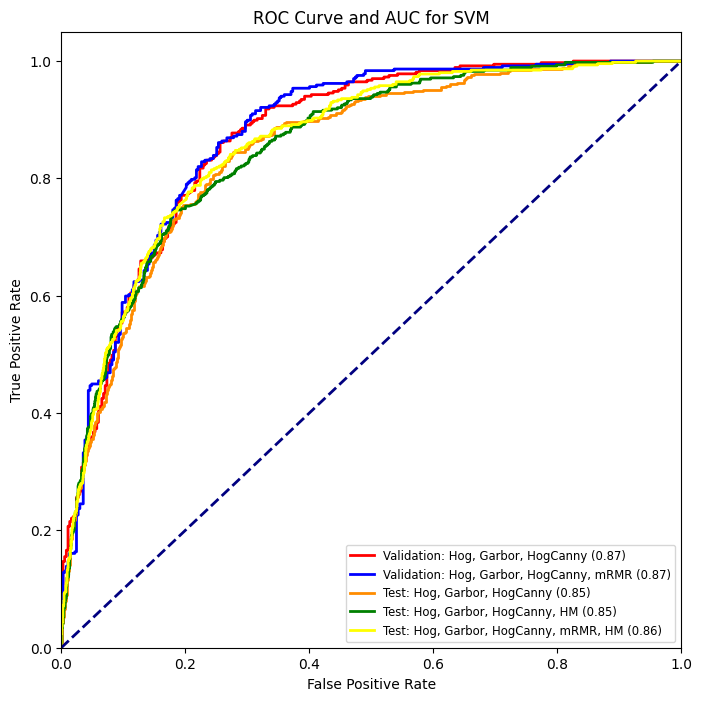

In [526]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Calculate ROC curve and ROC area for each model
fpr1, tpr1, _ = roc_curve(test_labels, y_pred_prob_1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(test_labels, y_pred_prob_2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(test_labels, y_pred_prob_3)
roc_auc3 = auc(fpr3, tpr3)

fpr1_val, tpr1_val, _ = roc_curve(y_val, y_pred_prob_1_val)
roc_auc1_val = auc(fpr1_val, tpr1_val)

fpr2_val, tpr2_val, _ = roc_curve(y_val, y_pred_prob_2_val)
roc_auc2_val = auc(fpr2_val, tpr2_val)

# Plot all ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr1_val, tpr1_val, color='red', lw=2, label='Validation: Hog, Garbor, HogCanny (%0.2f)' % roc_auc1_val)
plt.plot(fpr2_val, tpr2_val, color='blue', lw=2, label='Validation: Hog, Garbor, HogCanny, mRMR (%0.2f)' % roc_auc2_val)
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Test: Hog, Garbor, HogCanny (%0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='Test: Hog, Garbor, HogCanny, HM (%0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='yellow', lw=2, label='Test: Hog, Garbor, HogCanny, mRMR, HM (%0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC for SVM')
plt.legend(loc="lower right", fontsize='small')
plt.show()



## Export the model

In [215]:
model_path = 'models/weights/hog_alex_canny.pkl'

In [216]:
### Export model
joblib.dump(model, model_path)

['models/weights/hog_alex_canny.pkl']

## Load the model

In [160]:
model = joblib.load(model_path)

In [161]:
scaler = joblib.load('models/weights/scaler.pkl')


(-0.5, 999.5, 999.5, -0.5)

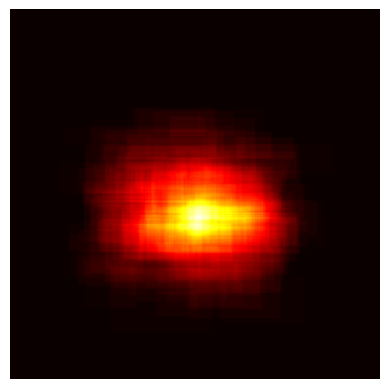

In [13]:
heatmap = np.load('./heatmap.npy')
coords = np.column_stack(np.where(heatmap > 0))
top_left = coords.min(axis=0)
bottom_right = coords.max(axis=0)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')

In [15]:
from utils.vis import draw_bboxes
root_path = 'MLDataset'
crop_data_path = os.path.join(root_path, 'crop_data_enhanced/images')
mode = 'test'
save_path = os.path.join(crop_data_path, mode)

image_files = glob.glob(os.path.join(root_path, image_folder, mode, '**/*.png'), recursive=True)


## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    print(f"Processing {image_file}")
    ### Parse label
    image = preprocess(image_file)
    image_name = os.path.basename(image_file)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]
    
    ## Save the cropped image
    class_name = image_file.split('/')[-2]
    os.makedirs(os.path.join(save_path, class_name), exist_ok=True)
    cv2.imwrite(os.path.join(os.path.join(save_path, class_name), image_name), roi_image)
    
    if 'normal' in image_file:
        continue
    label_path = image_file.replace('images', 'labels').replace('.png', '.txt')
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    ## Rescale the labels to cropped image
    new_labels = []
    for label in labels:
        c, *xyxy = label
        x1, y1, x2, y2 = xyxy
        roi_x1, roi_y1, roi_x2, roi_y2 = x1-scaled_roi_coords[1], y1-scaled_roi_coords[0], x2-scaled_roi_coords[1], y2-scaled_roi_coords[0]
        # new_labels.append([c, roi_x1, roi_y1, roi_x2, roi_y2])
        roi_h, roi_w = roi_image.shape
        norm_x1, norm_y1, norm_x2, norm_y2 = roi_x1/roi_w, roi_y1/roi_h, roi_x2/roi_w, roi_y2/roi_h
        norm_xc, norm_yc = (norm_x1 + norm_x2)/2, (norm_y1 + norm_y2)/2
        norm_w, norm_h = norm_x2 - norm_x1, norm_y2 - norm_y1
        new_labels.append([c, norm_xc, norm_yc, norm_w, norm_h])
    
    # draw_bboxes(roi_image, new_labels)
    ## Export new labels
    save_label_path = save_path.replace('images', 'labels')
    os.makedirs(os.path.join(save_label_path, class_name), exist_ok=True)
    new_label_path = os.path.join(save_label_path, class_name, image_name.replace('.png', '.txt'))
    f = open(new_label_path, 'w')
    for label in new_labels:
        f.write(f"{label[0]} {label[1]} {label[2]} {label[3]} {label[4]}\n")
    f.close()

    # _, fig = plt.subplots(1, 2, figsize=(10, 5))
    # fig[0].imshow(image, cmap='gray')
    # fig[0].axis('off')
    # fig[1].imshow(roi_image, cmap='gray')
    # fig[1].axis('off')

Processing MLDataset/images/test/normal/0045_0661159881_01_WRI-L1_M010.png
Processing MLDataset/images/test/normal/0073_1210326335_02_WRI-R1_M017.png
Processing MLDataset/images/test/normal/0087_0493070693_01_WRI-R2_F003.png
Processing MLDataset/images/test/normal/0351_0798024563_01_WRI-R2_M014.png
Processing MLDataset/images/test/normal/0669_0764349986_02_WRI-L1_F013.png
Processing MLDataset/images/test/normal/0019_0224740760_01_WRI-R1_M009.png
Processing MLDataset/images/test/normal/0022_0473957122_03_WRI-R2_M014.png
Processing MLDataset/images/test/normal/0073_1156812570_01_WRI-L2_M015.png
Processing MLDataset/images/test/normal/0074_0778270458_01_WRI-L1_F010.png
Processing MLDataset/images/test/normal/0023_0657842010_02_WRI-L2_M012.png
Processing MLDataset/images/test/normal/0386_0704200329_01_WRI-R2_M012.png
Processing MLDataset/images/test/normal/0048_0915622108_02_WRI-L2_F014.png
Processing MLDataset/images/test/normal/0002_0354485759_01_WRI-R2_F012.png
Processing MLDataset/imag